In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
#print(os.listdir("../input/chest_xray/chest_xray/"))
from glob import glob
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import fnmatch
import keras
from time import sleep
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Dropout,Flatten,BatchNormalization,MaxPooling2D,Activation
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as k

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
input_dir = '/content/drive/My Drive/chest_xray_4471/'
train_dir = input_dir +"train/"
test_dir = input_dir +"test/"
val_dir = input_dir +"val/"

In [0]:
# load each image three times
imagePatches = glob(input_dir + '*/**/*.jpeg', recursive=True)
print(len(imagePatches))

5856


In [0]:
# load images 3 times, in total 17568 images for training
pattern_normal = '*NORMAL*'
pattern_bacteria = '*_bacteria_*'
pattern_virus = '*_virus_*'

normal = fnmatch.filter(imagePatches, pattern_normal)
bacteria = fnmatch.filter(imagePatches, pattern_bacteria)
virus = fnmatch.filter(imagePatches, pattern_virus)
x = []
y = []
i = 0
for img in imagePatches:
    print(i)
    i = i+1
    full_size_image = cv2.imread(img)
    im = cv2.resize(full_size_image, (100, 100), interpolation=cv2.INTER_CUBIC)
    x.append(im)
    if img in normal:
        y.append(0)
    elif img in bacteria:
        y.append(1)
    elif img in virus:
        y.append(1)
    else:
        #break
        print('no class')
x = np.array(x)
y = np.array(y)

流式输出内容被截断，只能显示最后 5000 行内容。
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 101)
y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)
del x, y

In [0]:
import tensorflow as tf

In [0]:
bnmomemtum=0.9
def fire(x, squeeze, expand):
  y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
  y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
  y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
  y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
  y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
  y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
  return tf.keras.layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

x = tf.keras.layers.Input(shape=[100, 100, 3]) # input is 192x192 pixels RGB

y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(64, 128)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(2, activation='softmax')(y)

model = tf.keras.Model(x, y)

model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_82 (Conv2D)              (None, 100, 100, 32) 896         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_81 (BatchNo (None, 100, 100, 32) 128         conv2d_82[0][0]                  
__________________________________________________________________________________________________
conv2d_83 (Conv2D)              (None, 100, 100, 24) 792         batch_normalization_81[0][0]     
____________________________________________________________________________________________

In [0]:
#from tf.keras.callbacks import ModelCheckpoint
es = tf.keras.callbacks.EarlyStopping(patience=20)
mcp = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/My Drive/chest_xray_4471/squeeze_change_ds_bn9', monitor = 'val_accuracy', save_best_only=True, save_weights_only=True)
hist = model.fit(x_train, y_train, batch_size = 32, epochs = 40, verbose=1,  validation_split=0.2, callbacks=[mcp])

Epoch 1/40
118/118 [==============================] - 4s 31ms/step - loss: 0.2889 - accuracy: 0.8948 - val_loss: 0.2445 - val_accuracy: 0.8975
Epoch 2/40
118/118 [==============================] - 3s 27ms/step - loss: 0.1654 - accuracy: 0.9378 - val_loss: 0.5304 - val_accuracy: 0.7812
Epoch 3/40
118/118 [==============================] - 3s 28ms/step - loss: 0.1444 - accuracy: 0.9450 - val_loss: 0.2992 - val_accuracy: 0.8826
Epoch 4/40
118/118 [==============================] - 3s 28ms/step - loss: 0.1210 - accuracy: 0.9568 - val_loss: 0.3749 - val_accuracy: 0.8420
Epoch 5/40
118/118 [==============================] - 3s 28ms/step - loss: 0.1002 - accuracy: 0.9642 - val_loss: 5.2144 - val_accuracy: 0.2988
Epoch 6/40
118/118 [==============================] - 3s 28ms/step - loss: 0.0958 - accuracy: 0.9642 - val_loss: 2.6348 - val_accuracy: 0.3703
Epoch 7/40
118/118 [==============================] - 3s 28ms/step - loss: 0.0850 - accuracy: 0.9701 - val_loss: 0.3021 - val_accuracy: 0.8975

In [0]:
model.load_weights('/content/drive/My Drive/chest_xray_4471/squeeze_change_ds_es2') #es = 20

In [0]:
from sklearn.metrics import classification_report
pred = model.predict(x_test)
print(classification_report(np.argmax(y_test, axis = 1),np.argmax(pred, axis = 1)))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       327
           1       0.96      0.99      0.97       845

    accuracy                           0.96      1172
   macro avg       0.96      0.94      0.95      1172
weighted avg       0.96      0.96      0.96      1172



In [0]:
test_loss, test_score = model.evaluate(x_test, y_test)
print("loss:", test_loss)
print("accuracy:", test_score)

37/37 [==============================] - 0s 8ms/step - loss: 0.1573 - accuracy: 0.9616
loss: 0.15729127824306488
accuracy: 0.961604118347168


In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.grid(b=False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

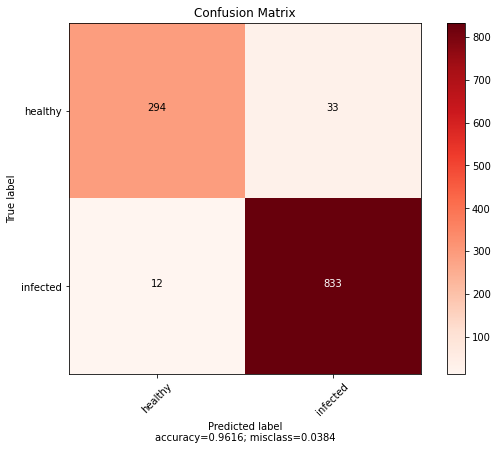

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test, axis = 1),np.argmax(pred, axis = 1))
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      cmap ='Reds',
                      target_names = ['healthy','infected'],
                      title        = "Confusion Matrix")

In [0]:
model.load_weights('/content/drive/My Drive/chest_xray_4471/squeeze_change_ds_es')  #es = 10

In [0]:
from sklearn.metrics import classification_report
pred = model.predict(x_test)
print(classification_report(np.argmax(y_test, axis = 1),np.argmax(pred, axis = 1)))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       327
           1       0.98      0.98      0.98       845

    accuracy                           0.97      1172
   macro avg       0.96      0.96      0.96      1172
weighted avg       0.96      0.97      0.97      1172



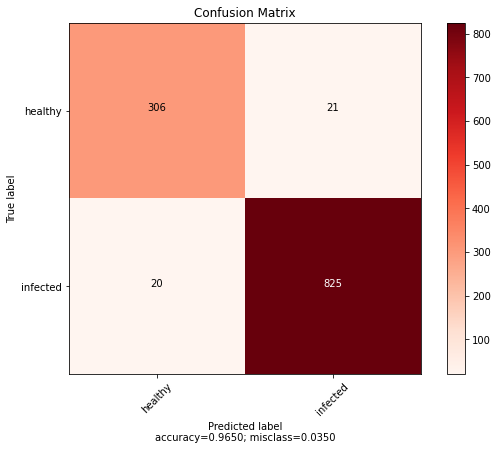

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test, axis = 1),np.argmax(pred, axis = 1))
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      cmap ='Reds',
                      target_names = ['healthy','infected'],
                      title        = "Confusion Matrix")

In [0]:
model.load_weights('/content/drive/My Drive/chest_xray_4471/squeeze_change_ds') #no es

In [0]:
from sklearn.metrics import classification_report
pred = model.predict(x_test)
print(classification_report(np.argmax(y_test, axis = 1),np.argmax(pred, axis = 1)))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       327
           1       0.97      0.97      0.97       845

    accuracy                           0.96      1172
   macro avg       0.95      0.95      0.95      1172
weighted avg       0.96      0.96      0.96      1172



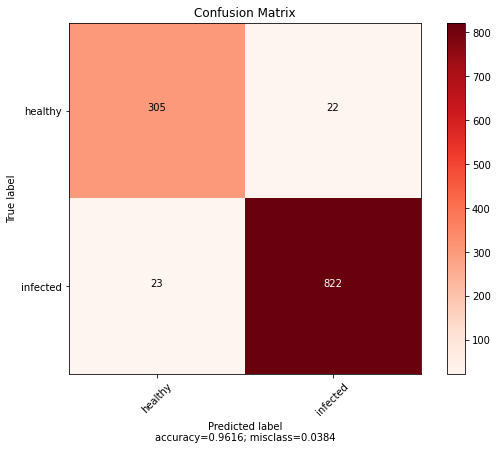

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test, axis = 1),np.argmax(pred, axis = 1))
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      cmap ='Reds',
                      target_names = ['healthy','infected'],
                      title        = "Confusion Matrix")

In [0]:
model.load_weights('/content/drive/My Drive/chest_xray_4471/squeeze_change_ds_bn9') #no es

In [0]:
from sklearn.metrics import classification_report
pred = model.predict(x_test)
print(classification_report(np.argmax(y_test, axis = 1),np.argmax(pred, axis = 1)))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       327
           1       0.97      0.99      0.98       845

    accuracy                           0.97      1172
   macro avg       0.97      0.95      0.96      1172
weighted avg       0.97      0.97      0.97      1172



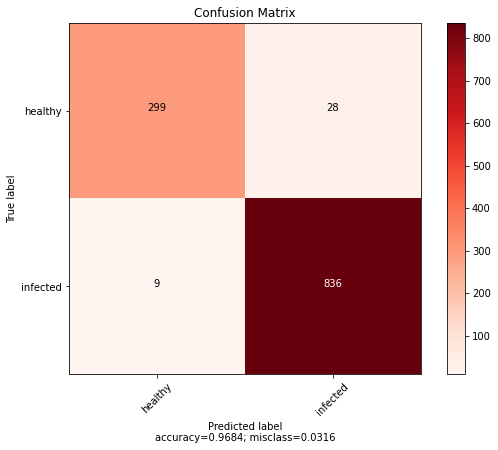

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test, axis = 1),np.argmax(pred, axis = 1))
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      cmap ='Reds',
                      target_names = ['healthy','infected'],
                      title        = "Confusion Matrix")